# Image Segmentation 
An important subject within computer vision is image segmentation. It is the process of dividing an image into different regions based on the characteristics of pixels to identify objects or boundaries to simplify an image and more efficiently analyze it.
_source_ : https://ai.stanford.edu/~syyeung/cvweb/tutorial3.html#:~:text=Another%20important%20subject%20within%20computer,and%20more%20efficiently%20analyze%20it

Applications of Image Segmentation Include: 

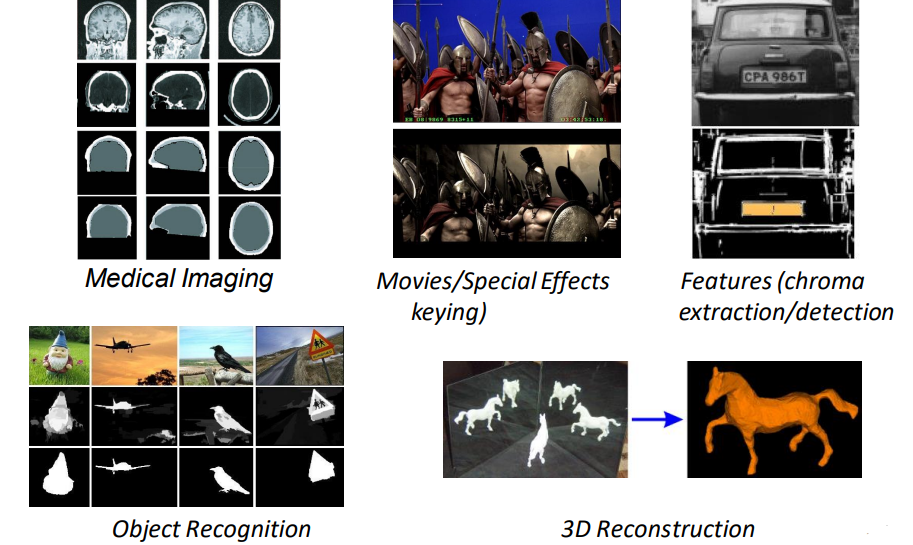


There are many different image segmentation techniques in the literature:

•Histogram-based methods (thresholds)

• Clustering-based methods

• Edge detection methods

• Region growing methods

• Graph partitioning methods

• Watershed transformation

• Model-based segmentation

• Multi-scale segmentation


# 1. Region Growing Image Segmentation
Region growing is a simple region-based image segmentation method. It is also classified as a pixel-based image segmentation method since it involves the selection of initial seed points.

_source_ : https://en.wikipedia.org/wiki/Region_growing#:~:text=Region%20growing%20is%20a%20simple,selection%20of%20initial%20seed%20points.

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import deque

def show(image = None,title = "Image"):
    size = 8
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

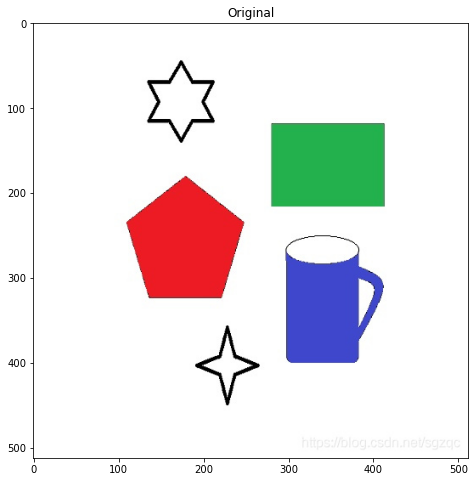

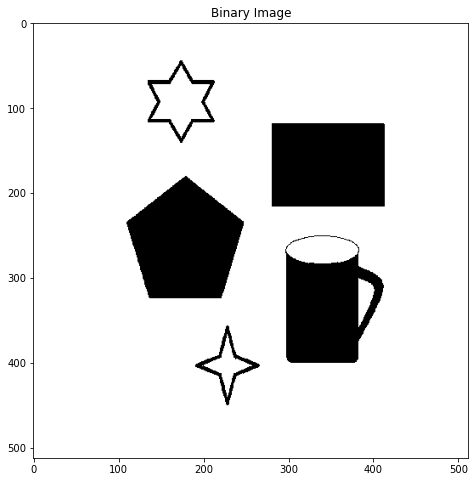

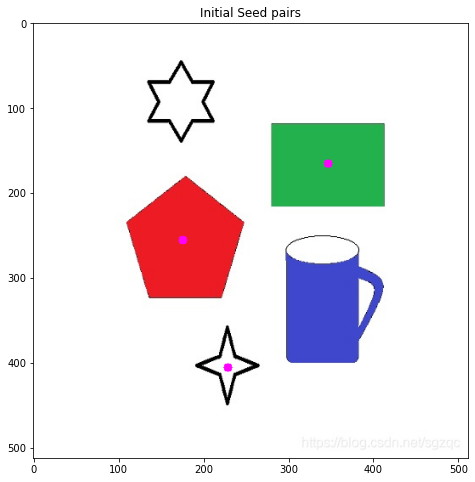

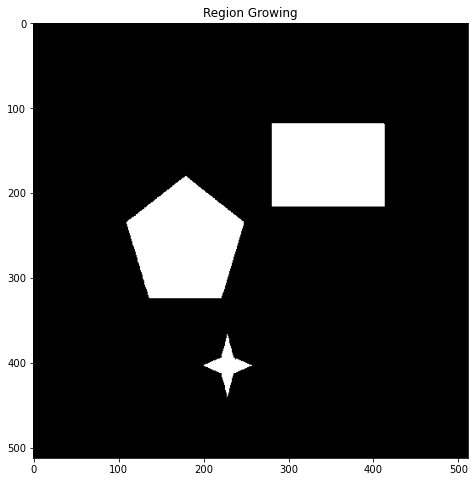

In [22]:
image = cv2.imread('images/region_grow.jpg')
show(image,'Original')

#Gray Scale:
im_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

def get_binary_img(img):
    # gray img to binary image
    bin_img = np.zeros(shape=(img.shape), dtype=np.uint8)
    h = img.shape[0]
    w = img.shape[1]
    for i in range(h):
        for j in range(w):
            bin_img[i][j] = 255 if img[i][j] > 127 else 0
    return bin_img

bin_img = get_binary_img(im_gray)
show(bin_img,'Binary Image')


#Start from an initial seed point:
out_img = np.zeros(shape=(bin_img.shape), dtype=np.uint8)

# Select initial 3 A seed point 
seeds = [(176,255),(229,405),(347,165)]


for seed in seeds:
    x = seed[0]
    y = seed[1]
    image2 = cv2.circle(image, (x,y), radius=5, color=(255, 0, 255), thickness=-1) 
    out_img[y][x] = 255
     
    
show(image2, 'Initial Seed pairs')

h, w = im_gray.shape
directs = [(-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1),(-1,1),(-1,0)] # 8 neighbourhood
visited = np.zeros(shape=(bin_img.shape), dtype=np.uint8)
while len(seeds):
    seed = seeds.pop(0)
    x = seed[0]
    y = seed[1]
    # visit point (x,y)
    visited[y][x] = 1
    for direct in directs:
        cur_x = x + direct[0]
        cur_y = y + direct[1]
# illegal 
        if cur_x <0 or cur_y<0 or cur_x >= w or cur_y >=h :
            continue
# Not visited and belong to the same target 
        if (not visited[cur_y][cur_x]) and (bin_img[cur_y][cur_x]==bin_img[y][x]) :
            out_img[cur_y][cur_x] = 255
            visited[cur_y][cur_x] = 1
            seeds.append((cur_x,cur_y))


show(out_img,"Region Growing")




# 2. Watershed Image Segmentation
A grayscale image can be seen as a topographic surface

– Intensity as a height value

• Three types of points:

– Local minima

– Points at which a drop of water would fall to a given minima

– Points at which a drop of water could fall into two (or more) different minima


• Flood the surface from the minima

– Each flooded region is a catchment basin

• Prevent merging of water from different basins

– When two catchment basins merge, build a dam between them

– The dam is taller than any pixel in the image

– Dam points are called watershed lines (points of type 3)

– The watershed lines are the boundary of the segments


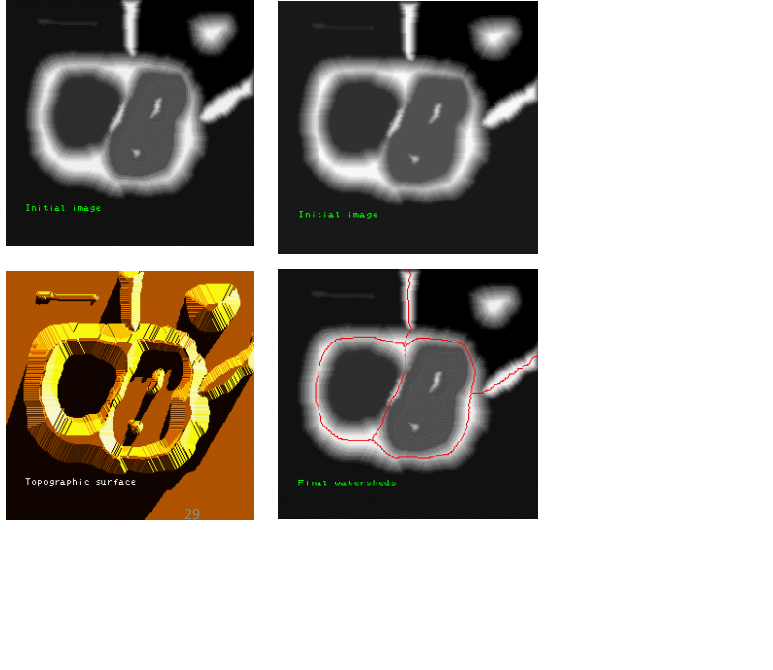



https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html


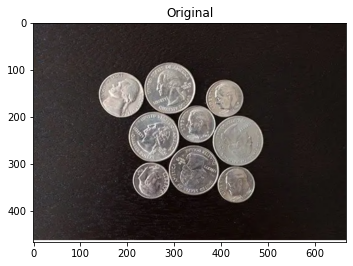

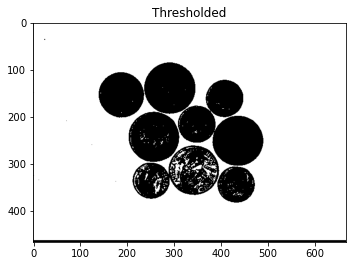

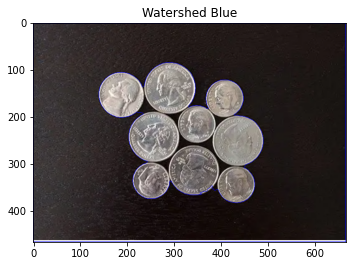

In [33]:
image = cv2.imread('images/coin_example.png')
show(image,"Original")

gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #grayscaling

ret , thresh = cv2.threshold(gray_img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) #thresholding
show(thresh,"Thresholded")


#Noise Removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)



# Marker labelling
# Connected Components determines the connectivity of blob-like regions in a binary image.
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]

show(image, "Watershed Blue")